## Example: Gaussian mixtures on iris dataset

We will consider different types of Gaussian mixture models fitted with EM algorithm on iris dataset. Parametrisation will use both the means and the covariance matrices of $K$ mixture components $f(x|\phi_k)$, given by
\begin{equation}
\label{eq:normal_mixture}
 f(x|\phi_k) = (2\pi)^{-\frac{p}{2}} |\Sigma_k|^{-\frac{1}{2}}\exp\left(-\frac{1}{2}(x-\mu_k)^\top\Sigma_k^{-1}(x-\mu_k)\right),
\end{equation}
with $\phi_k=(\mu_k,\Sigma_k)$ and the overall parameters are given by $\theta=(\phi_1,\ldots,\phi_K;\pi_1,\ldots,\pi_K)$. 

In [1]:
#helper function to visualise covariance structure of fitted Gaussian components
from matplotlib.patches import Ellipse
def plot_cov_ellipse(cov, pos, col='b', nstd=2, ax=None, **kwargs):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    if ax is None:
        ax = plt.gca()
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, color=col, alpha=0.2,**kwargs)
    ax.add_artist(ellip)
    return ellip

Let us load and inspect classical ```iris``` data, consisting of 50 samples from each of the three species of Iris flower.

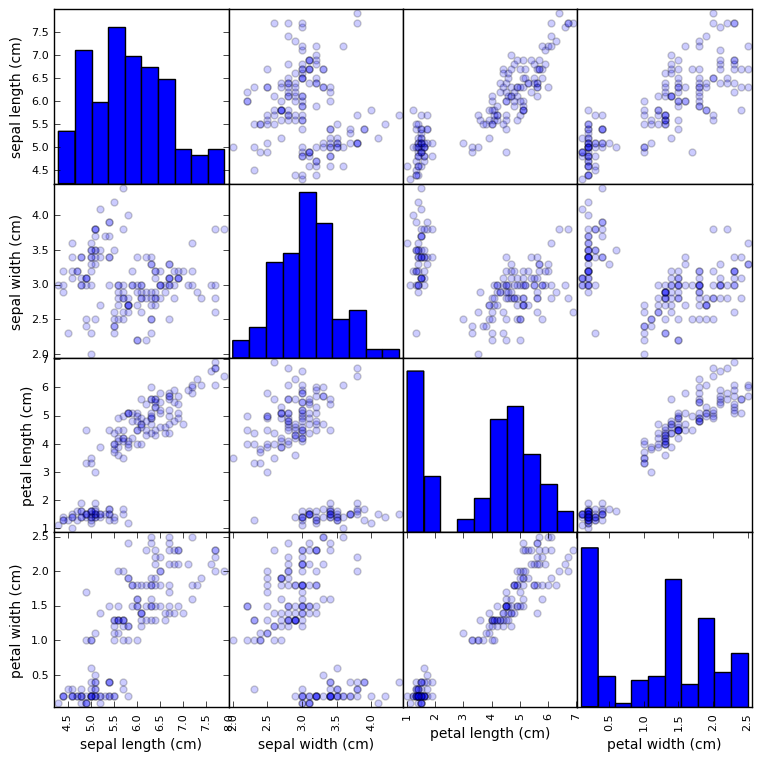

In [21]:
from sklearn import cluster, datasets
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

colors = ['navy', 'turquoise', 'darkorange']
markers = ['+','*','x']

#load iris data; pairwise plots
iris = datasets.load_iris()
df=pd.DataFrame(iris.data,columns = iris.feature_names)
axes = pd.tools.plotting.scatter_matrix(df, figsize=(9, 9), s=100, alpha=0.2)
plt.show()

Let us use `petal length` and `petal width` dimensions and run the good old $K$-means with $K=3$. 

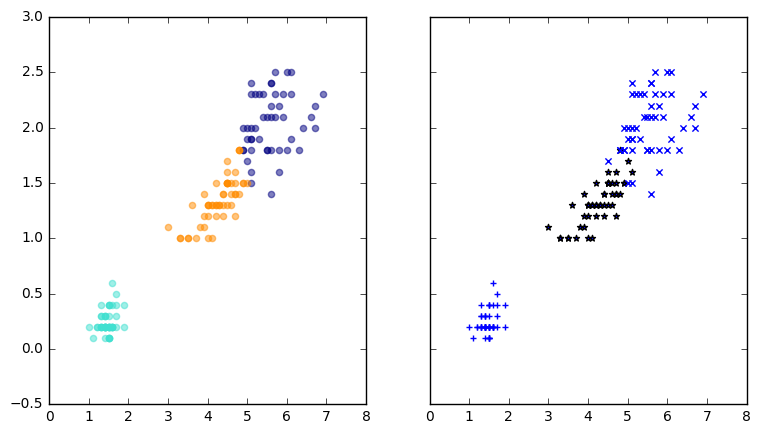

In [29]:
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(iris.data[:,2:4])
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9,5))
for n in range(kmeans.n_clusters):
    data_kmeanslabels = iris.data[kmeans.labels_ == n]
    ax1.scatter(data_kmeanslabels[:, 2], data_kmeanslabels[:, 3], color=colors[n], alpha=0.5)
    data_truelabels = iris.data[iris.target == n]
    ax2.scatter(data_truelabels[:, 2], data_truelabels[:, 3], marker=markers[n])
plt.show()

Different colors correspond to the clusters obtained by $K$-means, whereas different markers correspond to the original class labels: `setosa`, `virginica`, `versicolor`. The hard assignments of $K$-means do not reflect any uncertainty in the cluster allocation whereas there is a clear overlap in the true labels.

Now, let us consider the following Gaussian mixture models with different covariance structures:
* `spherical`: $\Sigma_k=\sigma_k^2 I$, i.e. all mixture components have spherical, but possibly different covariance matrices.
* `diagonal`: each $\Sigma_k$ is diagonal, i.e. contours of the mixture components are axis-aligned
* `tied`: $\Sigma_k=\Sigma$, i.e. all mixture components share the same covariance matrix, which need not be diagonal
* `full`: all mixture components are free to have a full $\Sigma_k$ of its own.

We will use $K=3$ mixture components.

In [31]:
# Try GMMs using different types of covariances in 2d: petal length vs petal width
estimators = dict((cov_type, GaussianMixture(n_components=3,
                   covariance_type=cov_type, max_iter=20, random_state=0))
                  for cov_type in ['spherical', 'diag', 'tied', 'full'])
for (name,estimator) in estimators.items():
    estimator.fit(iris.data[:,2:4]) ## fits a mixture model using EM

Let us visualise the results. Markers below denote the original class labels (remember that these are _not used_ in fitting the mixture models).

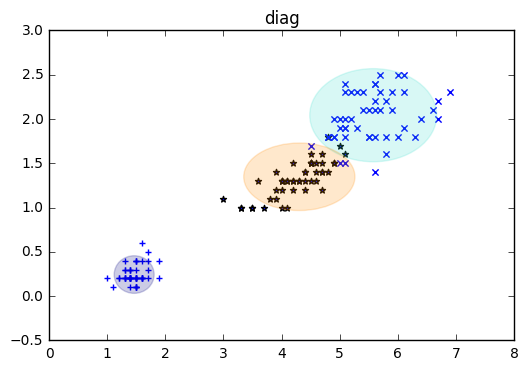

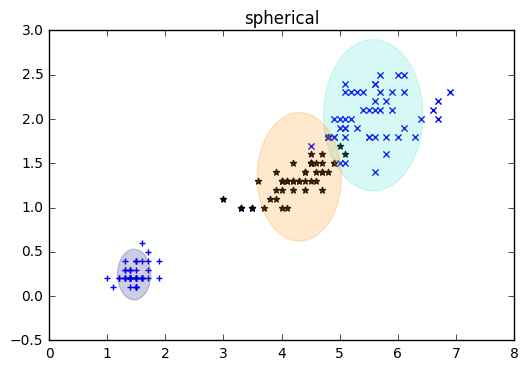

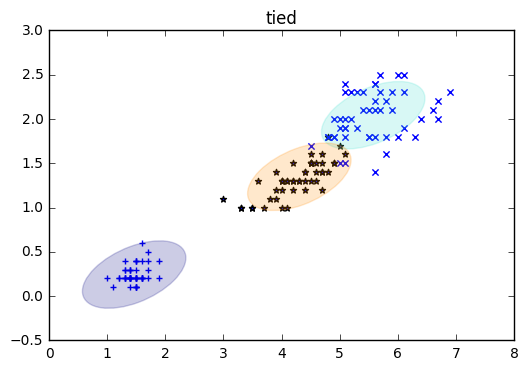

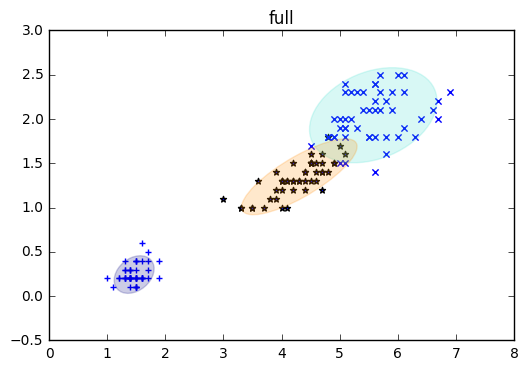

In [32]:

for (name,gmm) in estimators.items():
    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 2], data[:, 3], marker=markers[n])
        if gmm.covariance_type == 'full':
            cov = gmm.covariances_[n]
        elif gmm.covariance_type == 'tied':
            cov = gmm.covariances_
        elif gmm.covariance_type == 'diag':
            cov = np.diag(gmm.covariances_[n])
        elif gmm.covariance_type == 'spherical':
            cov = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        #print(cov)
        pos = estimator.means_[n]
        #print(pos)
        plot_cov_ellipse(cov,pos,col=color)
    plt.title(name)
    plt.show()